## New York Taxi Tip & Fare Prediction 

My detail execution flow was described as below steps:

**STEP 1. LOAD AND SPLIT DATA**
- Load the taxi-train.csv dataset
- Split the data into train (60%), validation (20%), and test (20%) sets
- The test set (with target) will remain untouched for final evaluation
- Load taxi-test.csv dataset for final prediction (remain untouched thourghout the process, prediction for this will be given in step 4)

**STEP 2.1. DATA EXPLORATION (ONLY BASE ON train_df, TO AVOID BIAS OPINION, DATA LEAKAGE)**
- Display general descriptive information of the data (max, min, std, etc.)
- Show the count of null values, distinct values, and zeros for each field
- Show a cluster chart combining longitude and latitude information, and display the most common pickup and drop-off spots 
→ It has been observed that there are 3 main pickup/drop-off spots, which can be categorized into three groups
- Visualize longtitude, latitude of pick-up/drop-off using binning method
  
**STEP 2.2. DATA PREPROCESSING (BASED ON KNOWLEDGE FROM train_df TO DEFINE LOGIC FOR FEATURE PROCESSING, APPLY TO ALL DATASET)**
- Use KNN to cluster the most common drop-off/pick-up spots (KNN model is fitted only on train_df to avoid data leakage)   
  *<ins>*Note*</ins>: I experimented with binning longitude and latitude, but ultimately chose the clustering method, as it might better encapsulate the information from both longitude and latitude*
- Process date-time related fields including: pickup_hour, pickup_day, pickup_month, pickup_weekday, trip_duration, trip_speed, etc
- Bucketize rare categorical values (based only on train_df frequency counts to decide rare categories for the validation and test data, ensuring no data leakage)
- Remove invalid values (e.g., negative fares, zero distances) and unused information (e.g., the tip_paid boolean column, which is derived from the target tip_amount)

**STEP 3. HYPERPARAMETER TUNING WITH RANDOMIZEDSEARCHCV**
- Define model_dict (the parameter grid for RandomizedSearchCV of three models: RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor)
- Define a preprocessor to automatically detect and classify columns into numerical and categorical. Numerical columns will be rescaled, and categorical columns will be one-hot encoded

**STEP 3.1. AND 3.2. TUNING WITH RANDOMIZEDSEARCHCV (SAME PROCEDURE FOR FARE_AMOUNT AND TIP_AMOUNT)**
- Data Sampling: Sample 100,000 rows from train_df (X_train, y_train_tip) to create X_sample and y_sample. This smaller sample is used for the initial hyperparameter tuning process to reduce computation time
- RandomizedSearchCV is then used to perform a hyperparameter search on the sampled data (X_sample, y_sample). It explores 10 different combinations of hyperparameters (n_iter=10) for each model, using 3-fold cross-validation (cv=3) and a negative root mean squared error (neg_root_mean_squared_error) as the scoring metric
- After the search, the cross-validation results are sorted, and the top 2 hyperparameter candidates (top_n = 2) for each model are identified based on their performance (validation RMSE). These top 2 hyperparameter combinations will be retrained on the full train_df and evaluated based on the validation RMSE. The best hyperparameter combination for each of the three models will be printed out  
*<ins>*Note*</ins>: The approach of hyperparameter tuning using sampled data and retraining the top hyperparameter combinations is adapted from this research (https://arxiv.org/pdf/2302.03845).*

**STEP 4. RMSE RESULTS (ON TEST DATA-SPLITED FROM taxi-train.csv) AND BEST HYPER-PARAMETER COMBINATIONS, GIVE PREDICTION ON TEST DATASET (taxi-test.csv)**
- Print the RMSE result on the test dataset (splited from taxi-train.csv) for the 3 best models (RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor) and their respective parameter combinations
- Print out sample predictions for the test data (taxi-test.csv)
- Detail RMSE on test data (taxi-train.csv), best hyperparameter, fare & tip amount prediction are as follows:  
- <ins>*For fare_amount*</ins>  
GradientBoost: Test dataset RMSE = 1.272, Best Params = {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
AdaBoost: Test dataset RMSE = 1.729, Best Params = {'model__n_estimators': 200, 'model__learning_rate': 0.01}
RandomForest: Test dataset RMSE = 1.338, Best Params = {'model__n_estimators': 200, 'model__max_depth': 10}
- <ins>*For tip_amount*</ins>  
GradientBoost: Test dataset RMSE = 0.624, Best Params = {'model__n_estimators': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1}
AdaBoost: Test dataset RMSE = 0.649, Best Params = {'model__n_estimators': 100, 'model__learning_rate': 0.01}
RandomForest: Test dataset RMSE = 0.634, Best Params = {'model__n_estimators': 200, 'model__max_depth': 10}

- <ins>*Sample of prediction on fare_amount for test data are:*</ins>  
[7.05215171, 15.15459294, 7.49546983, 9.05407284, 8.49709179, 6.66546121, 7.59512944, 8.04066859, 4.67566227, 4.14171189]
- <ins>*Sample of prediction on tip_amount for test data are:*</ins>  
[1.45102935e+00, 2.56366799e+00, 0.00000000e+00, 1.78416101e+00, 9.17143882e-04, 2.05328454e-04, 2.45541256e-04, 1.63661640e+00 , 0.00000000e+00, 2.96928128e-01]

**STEP 5. FEATURES IMPORTANCE ANALYSIS (5 FEATURES)**  
<ins>*For fare_amount:*</ins>
- The two variables, num__trip_duration and num__trip_distance, consistently account for the fare amount (total always > 80% of prediction), and this trend remains consistent across all models.
- Other factors related to pick-up and drop-off (e.g., num__dropoff_longitude, num__pickup_longitude, etc.) also appear in the top 5, but with less importance (total always <= 10% of prediction values). This shows that pick-up and drop-off locations do influence fare_amount, although not as strongly as trip duration and distance.

<ins>*For tip_amount:*</ins>
- For all models (GradientBoost, AdaBoost, RandomForest), cat__payment_type_CRD is the most influential variable (>= 0.6 for all models). This indicates that credit card (CRD) payments are strongly predictive of receiving a tip, suggesting that trips with credit card payments are more likely to generate higher tips
- In addition, the two variables num__trip_distance and num__trip_duration consistently stay in the top 5 highest-influencing features, showing their high importance toward tip_amount predictions

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
import pytz
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from joblib import Memory
import time
import os
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

## STEP 1. LOAD AND SPLIT DATA

In [3]:
# Load the dataset
train_df = pd.read_csv("./_data/taxi-train.csv")

# Split into train, validation, test (60/20/20)
train_full, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_full, test_size=0.25, random_state=42)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))
print("Test size:", len(test_df))

Train size: 643146
Valid size: 214382
Test size: 214382


In [4]:
test_df_file_no_target = pd.read_csv("./_data/taxi-test.csv")

## STEP 2.1 DATA EXPLORATION

In [4]:
# 2.1.1 Show general descriptive information of raw data
train_df.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count     643146.000000    643146.000000      643146.000000     643146.000000   
mean         -73.977078        40.756833         -73.975557         40.757280   
std            0.014372         0.018204           0.015735          0.018864   
min          -73.999999        40.700005         -73.999999         40.700005   
25%          -73.988180        40.744772         -73.987306         40.745322   
50%          -73.979833        40.757792         -73.978589         40.758250   
75%          -73.968106        40.769472         -73.966502         40.770467   
max          -73.900009        40.799997         -73.900008         40.799999   

           rate_code  passenger_count  trip_distance    fare_amount  \
count  539530.000000    643146.000000  643146.000000  643146.000000   
mean        1.004917         1.690759       1.811842       8.456755   
std         0.178663         1.311123       1.221065       4.017981   
min         0.000000         1.000000       0.010000       2.500000   
25%         1.000000         1.000000       0.950000       5.700000   
50%         1.000000         1.000000       1.500000       7.500000   
75%         1.000000         2.000000       2.300000      10.100000   
max        99.000000         6.000000      15.500000     200.000000   

          tip_amount       tip_paid  
count  643146.000000  643146.000000  
mean        0.783948       0.422420  
std         1.198595       0.493945  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         1.500000       1.000000  
max       144.400000       1.000000

In [35]:
# # 2.1.2 Show null, distinct values, and zeros for each field
def analyze_dataframe_fields(df):
    # Automatically get numerical and categorical fields
    fields = df.columns.tolist()  # Get all column names in the dataframe
    
    # Calculate null, distinct values, and zero counts for all fields
    null_counts = df[fields].isnull().sum()
    distinct_counts = df[fields].nunique()
    zero_counts = (df[fields] == 0).sum()

    # Store the results in a DataFrame
    result_df = pd.DataFrame({
        'Null Count': null_counts,
        'Distinct Count': distinct_counts,
        'Zero Count': zero_counts
    })
    return result_df

# show statistics with train_df
result = analyze_dataframe_fields(train_df)
print(result)

                        Null Count  Distinct Count  Zero Count
vendor_id                        0               3           0
pickup_longitude                 0           68569           0
pickup_latitude                  0           98444           0
dropoff_longitude                0           75821           0
dropoff_latitude                 0          102666           0
passenger_count                  0               6           0
trip_distance                    0            1097           0
payment_type                     0               3           0
fare_amount                      0             528           0
tip_amount                       0             792      371193
pickup_hour                      0               1           0
pickup_day                       0               1           0
pickup_month                     0               1           0
pickup_weekday                   0               7       85927
is_weekend                       0               2     

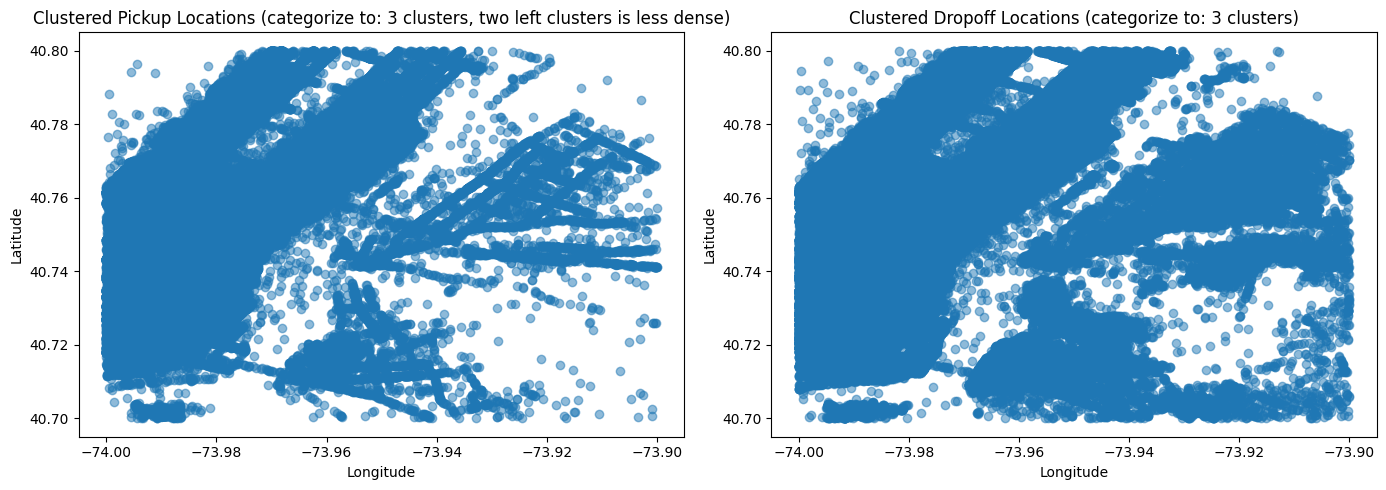

In [6]:
# 2.1.3 Combine longtitude and Latitude, show common pickup, drop of spots

# Extracting the coordinates for pickup and dropoff locations
pickup_coords = train_df[['pickup_longitude', 'pickup_latitude']]
dropoff_coords = train_df[['dropoff_longitude', 'dropoff_latitude']]

# Create subplots for side-by-side charts
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot for pickup locations
ax[0].scatter(pickup_coords['pickup_longitude'], pickup_coords['pickup_latitude'], cmap='viridis', alpha=0.5)
ax[0].set_title('Clustered Pickup Locations (categorize to: 3 clusters, two left clusters is less dense)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Scatter plot for dropoff locations
ax[1].scatter(dropoff_coords['dropoff_longitude'], dropoff_coords['dropoff_latitude'], cmap='plasma', alpha=0.5)
ax[1].set_title('Clustered Dropoff Locations (categorize to: 3 clusters)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Show the plots
plt.tight_layout()
plt.show()

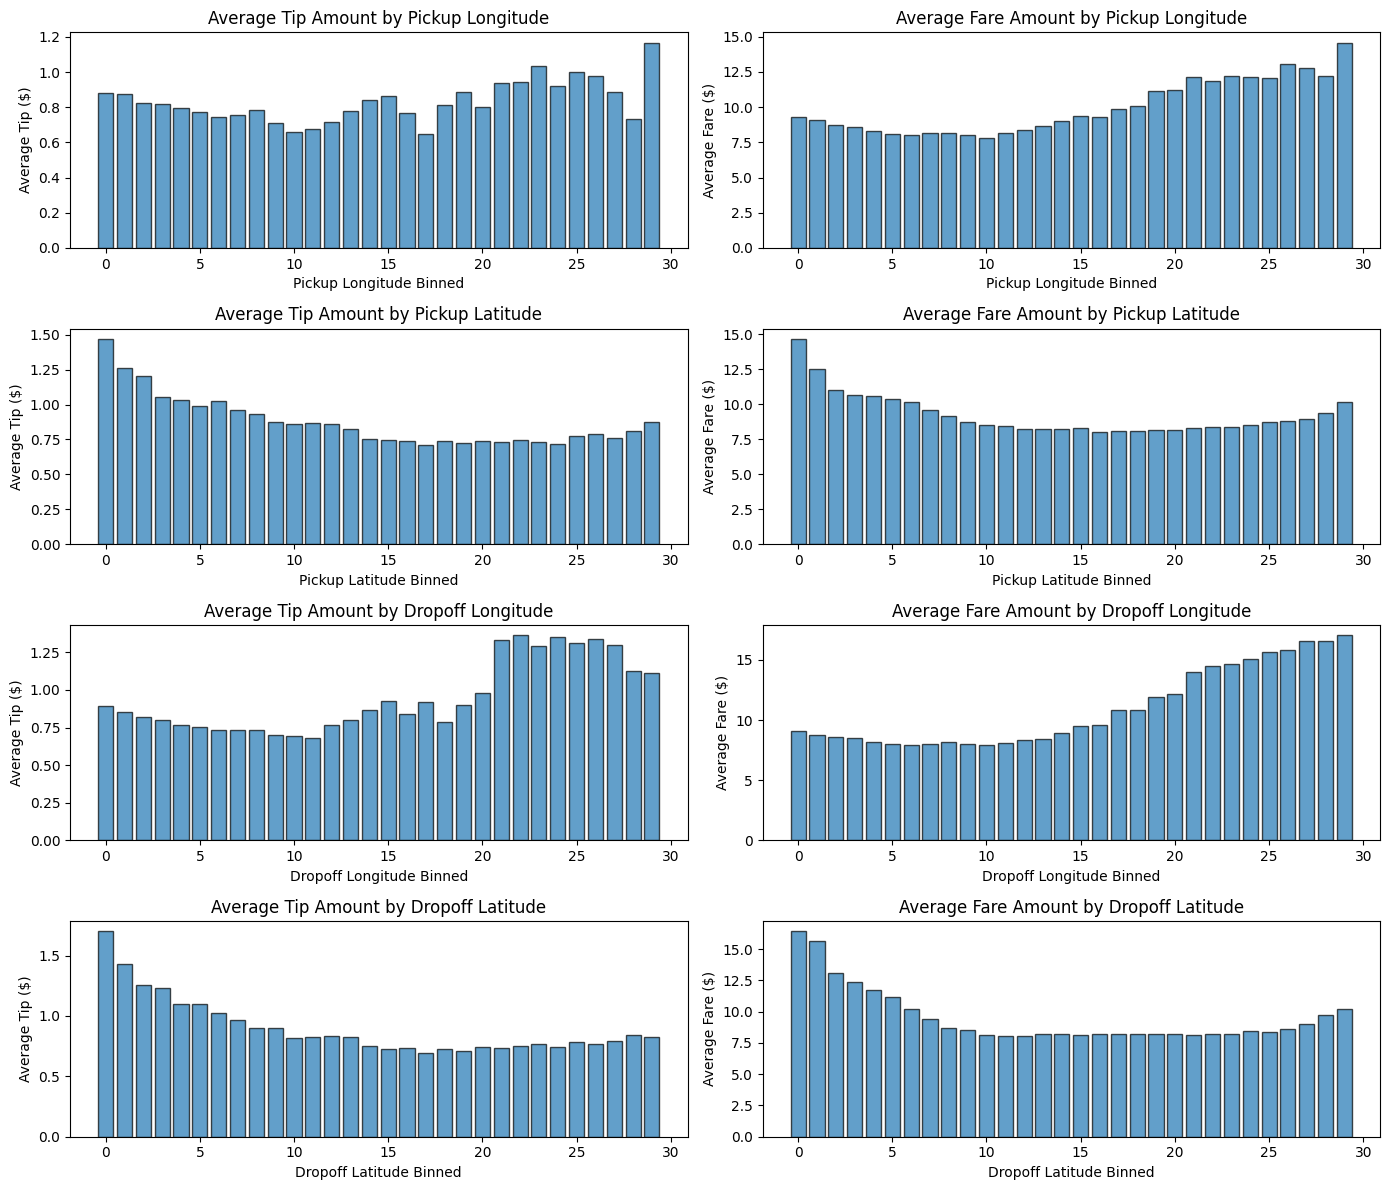

In [34]:
# 2.1.4 Visualize longtitude, latitude of pick-up/drop-off using binning method

df = train_df.copy()
GRID_SIZE = 30

# Create bins for longitude and latitude
pickup_lon_bins = np.linspace(df['pickup_longitude'].min(), df['pickup_longitude'].max(), GRID_SIZE + 1)
pickup_lat_bins = np.linspace(df['pickup_latitude'].min(), df['pickup_latitude'].max(), GRID_SIZE + 1)
dropoff_lon_bins = np.linspace(df['dropoff_longitude'].min(), df['dropoff_longitude'].max(), GRID_SIZE + 1)
dropoff_lat_bins = np.linspace(df['dropoff_latitude'].min(), df['dropoff_latitude'].max(), GRID_SIZE + 1)

# Sort into bios for pickup and drop off
df['pickup_lon_bin'] = pd.cut(df['pickup_longitude'], bins=pickup_lon_bins, labels=False, include_lowest=True)
df['pickup_lat_bin'] = pd.cut(df['pickup_latitude'], bins=pickup_lat_bins, labels=False, include_lowest=True)
df['dropoff_lon_bin'] = pd.cut(df['dropoff_longitude'], bins=dropoff_lon_bins, labels=False, include_lowest=True)
df['dropoff_lat_bin'] = pd.cut(df['dropoff_latitude'], bins=dropoff_lat_bins, labels=False, include_lowest=True)

# Calculate the average tip_amount and fare_amount in each longitude and latitude bin
agg_pickup_lon = df.groupby('pickup_lon_bin').agg(avg_tip=('tip_amount', 'mean'), avg_fare=('fare_amount', 'mean')).reset_index()
agg_pickup_lat = df.groupby('pickup_lat_bin').agg(avg_tip=('tip_amount', 'mean'), avg_fare=('fare_amount', 'mean')).reset_index()
agg_dropoff_lon = df.groupby('dropoff_lon_bin').agg(avg_tip=('tip_amount', 'mean'), avg_fare=('fare_amount', 'mean')).reset_index()
agg_dropoff_lat = df.groupby('dropoff_lat_bin').agg(avg_tip=('tip_amount', 'mean'), avg_fare=('fare_amount', 'mean')).reset_index()

# Draw out historgrams 
fig, ax = plt.subplots(4, 2, figsize=(14, 12))

# Histogram TIP - Pickup Longitude
ax[0, 0].bar(agg_pickup_lon['pickup_lon_bin'], agg_pickup_lon['avg_tip'], alpha=0.7, edgecolor='k')
ax[0, 0].set_title('Average Tip Amount by Pickup Longitude')
ax[0, 0].set_xlabel('Pickup Longitude Binned')
ax[0, 0].set_ylabel('Average Tip ($)')

# Histogram FARE - Pickup Longitude
ax[0, 1].bar(agg_pickup_lon['pickup_lon_bin'], agg_pickup_lon['avg_fare'], alpha=0.7, edgecolor='k')
ax[0, 1].set_title('Average Fare Amount by Pickup Longitude')
ax[0, 1].set_xlabel('Pickup Longitude Binned')
ax[0, 1].set_ylabel('Average Fare ($)')

# Histogram TIP - Pickup Latitude
ax[1, 0].bar(agg_pickup_lat['pickup_lat_bin'], agg_pickup_lat['avg_tip'], alpha=0.7, edgecolor='k')
ax[1, 0].set_title('Average Tip Amount by Pickup Latitude')
ax[1, 0].set_xlabel('Pickup Latitude Binned')
ax[1, 0].set_ylabel('Average Tip ($)')

# Histogram FARE - Pickup Latitude
ax[1, 1].bar(agg_pickup_lat['pickup_lat_bin'], agg_pickup_lat['avg_fare'], alpha=0.7, edgecolor='k')
ax[1, 1].set_title('Average Fare Amount by Pickup Latitude')
ax[1, 1].set_xlabel('Pickup Latitude Binned')
ax[1, 1].set_ylabel('Average Fare ($)')

# Histogram TIP - Dropoff Longitude
ax[2, 0].bar(agg_dropoff_lon['dropoff_lon_bin'], agg_dropoff_lon['avg_tip'], alpha=0.7, edgecolor='k')
ax[2, 0].set_title('Average Tip Amount by Dropoff Longitude')
ax[2, 0].set_xlabel('Dropoff Longitude Binned')
ax[2, 0].set_ylabel('Average Tip ($)')

# Histogram FARE - Dropoff Longitude
ax[2, 1].bar(agg_dropoff_lon['dropoff_lon_bin'], agg_dropoff_lon['avg_fare'], alpha=0.7, edgecolor='k')
ax[2, 1].set_title('Average Fare Amount by Dropoff Longitude')
ax[2, 1].set_xlabel('Dropoff Longitude Binned')
ax[2, 1].set_ylabel('Average Fare ($)')

# Histogram TIP - Dropoff Latitude
ax[3, 0].bar(agg_dropoff_lat['dropoff_lat_bin'], agg_dropoff_lat['avg_tip'], alpha=0.7, edgecolor='k')
ax[3, 0].set_title('Average Tip Amount by Dropoff Latitude')
ax[3, 0].set_xlabel('Dropoff Latitude Binned')
ax[3, 0].set_ylabel('Average Tip ($)')

# Histogram FARE - Dropoff Latitude
ax[3, 1].bar(agg_dropoff_lat['dropoff_lat_bin'], agg_dropoff_lat['avg_fare'], alpha=0.7, edgecolor='k')
ax[3, 1].set_title('Average Fare Amount by Dropoff Latitude')
ax[3, 1].set_xlabel('Dropoff Latitude Binned')
ax[3, 1].set_ylabel('Average Fare ($)')

plt.tight_layout()
plt.show()


## STEP 2.2 DATA PROCESSING

In [7]:
# Function to group data into 3 most comment drop-off/pick-up clusters

# Extract location data for clustering (pickup and dropoff coordinates together)
location_data = train_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

# Using KMeans to find clusters in both pickup and dropoff coordinates
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit KMeans on the training data only
kmeans.fit(location_data)

# Function to predict clusters and flag the data into pick-up/drop-off cluster
def pickup_dropoff_cluster(df, kmeans):
    print("===START PROCESS PICKUP-DROPOFF LOCATION==================================================================")
    # Predict clusters for all four coordinates (pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)
    df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
    df['dropoff_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
    
    print("Finished pickup dropoff processing")
    print('\n')
    return df

In [8]:
# function to process time-related features
def process_datetime(df):
    print("===START PROCESS DATETIME=================================================================================")
    # Time zone transformation
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    # Ensure timezone conversion works
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert('US/Eastern')
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime']).dt.tz_convert('US/Eastern')
    
    # Time in day classification
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    
    # (Saturday=5, Sunday=6) or (7-9 AM and 4-6 PM)
    df['is_weekend'] = df['pickup_weekday'].isin([5, 6])  
    df['is_rush_hour'] = df['pickup_hour'].isin([7, 8, 9, 16, 17, 18])  
    # Trip duration & Trip average speed
    df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0
    df['trip_speed'] = df['trip_distance'] / df['trip_duration']
    df['trip_duration_category'] = pd.cut(df['trip_duration'], bins=[0, 10, 30, 60, 120, np.inf], 
                                          labels=['short', 'medium', 'long', 'very_long', 'extra_long'])
    df['day_part'] = pd.cut(df['pickup_hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)    
    print("Finished datetime processing")
    print('\n')
    return df

In [9]:
# function to one hot encoding columns, categories appear <10% will be group to others  
categorical_cols = ["vendor_id", "rate_code", "payment_type", "pickup_hour", "pickup_day", "pickup_month", "pickup_weekday", "trip_duration_category", "day_part", "pickup_cluster", "dropoff_cluster"]

def bucketized_values(df, categorical_cols = categorical_cols, rare_ratio=0.1):
    print("===START BUCKETIZE=================================================================================")
    # Store rare categories for each column in a dictionary
    rare_categories_dict = {}
    total_rows = len(df)
    # For each column in the provided categorical columns
    for col in categorical_cols:
        freq = df[col].value_counts()
        # Calculate the ratio for each category
        ratio = freq / total_rows
        rare_categories = ratio[ratio < rare_ratio].index
        if len(rare_categories) > 0:
            print(f"Bucketizing rare categories in '{col}' (appearing in < {rare_ratio*100:.0f}% of data): {list(rare_categories)}")
            rare_categories_dict[col] = list(rare_categories)
    return rare_categories_dict

# Function to reflag the datasets based on the rare categories to bucketize (get from bucketized_values)
def reflag_df(df, rare_categories_dict):
    # Apply bucketization to the dataframe using rare categories from train_df
    for col, rare_categories in rare_categories_dict.items():
        # Replace rare categories with 'Other'
        df[col] = df[col].apply(lambda x: 'Other' if x in rare_categories else x)
    return df

In [10]:
def process_final(df):
    df = process_datetime(df)
    df = pickup_dropoff_cluster(df, kmeans)
    df['rate_code'] = df['rate_code'].fillna('Empty')
    return df

def remove_invalid_records(df):
    # 1. Remove rows where trip_duration is less than or equal to 0
    df = df[df['trip_duration'] > 0]
    # 2. Fill NaN values in trip_speed with the mean of the column
    if 'trip_speed' in df.columns:
        df['trip_speed'].fillna(df['trip_speed'].mean(), inplace=True)
    return df

In [11]:
%%time
# Apply feature processing to all datasets
train_df = process_final(train_df)
valid_df = process_final(valid_df)
test_df = process_final(test_df)
test_df_file_no_target = process_final(test_df_file_no_target)

# from train_df only, identify rare categories (<=10% appreance) to bucketize
rare_categories_dict = bucketized_values(train_df)

# bucketize all dataset
train_df = reflag_df(train_df, rare_categories_dict)
valid_df = reflag_df(valid_df, rare_categories_dict)
test_df = reflag_df(test_df, rare_categories_dict)
test_df_file_no_target = reflag_df(test_df_file_no_target, rare_categories_dict)

# Drop original unused columns and filter invalid data
cols_to_drop = ['pickup_datetime', 'dropoff_datetime', 'tip_paid', 'rate_code']
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
valid_df = valid_df.drop(columns=cols_to_drop, errors='ignore')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')
test_df_file_no_target = test_df_file_no_target.drop(columns=cols_to_drop, errors='ignore')

# Remove invalid datasets
train_df = remove_invalid_records(train_df)
valid_df = remove_invalid_records(valid_df)
test_df = remove_invalid_records(test_df)
test_df_file_no_target = remove_invalid_records(test_df_file_no_target)

===START PROCESS DATETIME=================================================================================
Finished datetime processing


===START PROCESS PICKUP-DROPOFF LOCATION==================================================================
Finished pickup dropoff processing


===START PROCESS DATETIME=================================================================================
Finished datetime processing


===START PROCESS PICKUP-DROPOFF LOCATION==================================================================
Finished pickup dropoff processing


===START PROCESS DATETIME=================================================================================
Finished datetime processing


===START PROCESS PICKUP-DROPOFF LOCATION==================================================================
Finished pickup dropoff processing


===START PROCESS DATETIME=================================================================================
Finished datetime processing


===START PROCESS

In [12]:
# Define target and features
targets = ['tip_amount', 'fare_amount']
features = [col for col in train_df.columns if col not in targets]

X_train = train_df[features]
X_valid = valid_df[features]
X_test = test_df[features]

y_train_tip = train_df['tip_amount']
y_valid_tip = valid_df['tip_amount']
y_test_tip  = test_df['tip_amount']

y_train_fare = train_df['fare_amount']
y_valid_fare = valid_df['fare_amount']
y_test_fare = test_df['fare_amount']

## STEP 3. HYPERPARAMETER TUNING WITH RANDOMIZEDSEARCHCV

In [13]:
# Automatically detect numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['fare_amount', 'tip_amount']]
categorical_cols = train_df.select_dtypes(exclude=['float64', 'int64', 'int32']).columns.tolist()

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Enable memory caching
memory = Memory(location=os.path.join(os.getcwd(), 'cachedir'), verbose=0)

In [14]:
# Models and parameter grids
model_dict = {
    'GradientBoost': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'RandomForest': RandomForestRegressor(n_jobs=-1)
}
param_grid = {
    'GradientBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__max_depth': [3, 5, 7]
    },
    'RandomForest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [10, 20, 30]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 1.0]
    }
}

### STEP 3.1 FOR TIP_AMOUNT

In [15]:
# Sample 100k rows for tunning
sample_size = 100000
sample_idx = np.random.choice(len(X_train), size=sample_size, replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train_tip.iloc[sample_idx]

In [16]:
%%time
# Store final comparison results
results_tip = {}
# Top hyperparameter candidates to keep for final evaluation 
top_n = 2

for name, model in model_dict.items():
    print(f"\nStarting hyperparameter tuning for: {name}")
    start_tune = time.time()

    # Pipeline setup
    pipe = Pipeline([('pre', preprocessor), ('model', model)], memory=memory)
    # Hyperparameter search
    search = RandomizedSearchCV(pipe,param_distributions=param_grid[name], n_iter=10, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, random_state=42, verbose=2)
    search.fit(X_sample, y_sample)
    tuning_time = time.time() - start_tune

    # Sort top N candidates
    top_candidates = sorted(zip(search.cv_results_['mean_test_score'], search.cv_results_['params']), key=lambda x: x[0], reverse=True)[:top_n]
    print(f"\nTop {top_n} candidates for {name}:")
    for i, (score, params) in enumerate(top_candidates):
        print(f"{i+1}: Validation RMSE = {-score:.4f}, Params = {params}")

    # Retrain and evaluate each top-N model
    retrain_results = []
    for i, (_, params) in enumerate(top_candidates):
        print(f"\nRetraining candidate #{i+1} for {name}...")
        # Prepare final model with extracted params
        final_model = model.__class__(**{k.replace('model__', ''): v for k, v in params.items()}, random_state=42)
        final_pipe = Pipeline([('pre', preprocessor), ('model', final_model)], memory=memory)
        start_train = time.time()
        final_pipe.fit(X_train, y_train_tip)
        training_time = time.time() - start_train
        preds = final_pipe.predict(X_valid)
        final_rmse = np.sqrt(mean_squared_error(y_valid_tip, preds))
        retrain_results.append({'model': final_pipe, 'params': params, 'rmse': final_rmse, 'training_time': training_time})
        print(f"Candidate #{i+1} Validation RMSE: {final_rmse:.4f}, Training Time: {training_time:.2f}s")

    # Select best of the top N
    best_result = min(retrain_results, key=lambda x: x['rmse'])
    print(f"\nSelected Final Model for {name}: Validation RMSE = {best_result['rmse']:.4f}")
    print(f"===========================================================================================================")
    
    # Store result
    results_tip[name] = {
        'best_model': best_result['model'],'best_params': best_result['params'],
        'validation_rmse_after_retraining': best_result['rmse'], 'tuning_time_sec': tuning_time,
        'training_time_sec': best_result['training_time'], 'top_candidates': retrain_results}


Starting hyperparameter tuning for: GradientBoost
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Top 2 candidates for GradientBoost:
1: Validation RMSE = 0.7814, Params = {'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1}
2: Validation RMSE = 0.7820, Params = {'model__n_estimators': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1}

Retraining candidate #1 for GradientBoost...
Candidate #1 Validation RMSE: 0.7539, Training Time: 142.09s

Retraining candidate #2 for GradientBoost...
Candidate #2 Validation RMSE: 0.7527, Training Time: 253.48s

Selected Final Model for GradientBoost: Validation RMSE = 0.7527

Starting hyperparameter tuning for: AdaBoost
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Top 2 candidates for AdaBoost:
1: Validation RMSE = 0.7957, Params = {'model__n_estimators': 50, 'model__learning_rate': 0.01}
2: Validation RMSE = 0.8119, Params = {'model__n_estimators': 100, 'model__learning_rate': 0.01}

Ret

### STEP 3.2 FOR FARE_AMOUNT

In [17]:
# Sample 100k rows for tuning
sample_size = 100000
sample_idx = np.random.choice(len(X_train), size=sample_size, replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train_fare.iloc[sample_idx]

In [18]:
%%time
# Store final comparison results
results_fare = {}
# Top hyperparameter candidates to keep for final evaulation 
top_n = 2

for name, model in model_dict.items():
    print(f"\nStarting hyperparameter tuning for: {name}")
    start_tune = time.time()

    # Pipeline setup
    pipe = Pipeline([('pre', preprocessor), ('model', model)], memory=memory)
    # Hyperparameter search
    search = RandomizedSearchCV(pipe,param_distributions=param_grid[name], n_iter=10, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, random_state=42, verbose=2)
    search.fit(X_sample, y_sample)
    tuning_time = time.time() - start_tune

    # Sort top N candidates
    top_candidates = sorted(zip(search.cv_results_['mean_test_score'], search.cv_results_['params']), key=lambda x: x[0], reverse=True)[:top_n]
    print(f"\nTop {top_n} candidates for {name}:")
    for i, (score, params) in enumerate(top_candidates):
        print(f"{i+1}: Validation RMSE = {-score:.4f}, Params = {params}")

    # Retrain and evaluate each top-N model
    retrain_results = []
    for i, (_, params) in enumerate(top_candidates):
        print(f"\nRetraining candidate #{i+1} for {name}...")
        # Prepare final model with extracted params
        final_model = model.__class__(**{k.replace('model__', ''): v for k, v in params.items()}, random_state=42)
        final_pipe = Pipeline([('pre', preprocessor), ('model', final_model)], memory=memory)
        start_train = time.time()
        final_pipe.fit(X_train, y_train_fare)
        training_time = time.time() - start_train
        preds = final_pipe.predict(X_valid)
        final_rmse = np.sqrt(mean_squared_error(y_valid_fare, preds))
        retrain_results.append({'model': final_pipe, 'params': params, 'rmse': final_rmse, 'training_time': training_time})
        print(f"Candidate #{i+1} Validation RMSE: {final_rmse:.4f}, Training Time: {training_time:.2f}s")

    # Select best of the top N
    best_result = min(retrain_results, key=lambda x: x['rmse'])
    print(f"\nSelected Final Model for {name}: Validation RMSE = {best_result['rmse']:.4f}")
    print(f"===========================================================================================================")
    
    # Store result
    results_fare[name] = {
        'best_model': best_result['model'],'best_params': best_result['params'],
        'validation_rmse_after_retraining': best_result['rmse'], 'tuning_time_sec': tuning_time,
        'training_time_sec': best_result['training_time'], 'top_candidates': retrain_results}


Starting hyperparameter tuning for: GradientBoost
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Top 2 candidates for GradientBoost:
1: Validation RMSE = 1.2783, Params = {'model__n_estimators': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1}
2: Validation RMSE = 1.2812, Params = {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}

Retraining candidate #1 for GradientBoost...
Candidate #1 Validation RMSE: 1.3234, Training Time: 577.63s

Retraining candidate #2 for GradientBoost...
Candidate #2 Validation RMSE: 1.2981, Training Time: 1139.86s

Selected Final Model for GradientBoost: Validation RMSE = 1.2981

Starting hyperparameter tuning for: AdaBoost
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Top 2 candidates for AdaBoost:
1: Validation RMSE = 1.6858, Params = {'model__n_estimators': 200, 'model__learning_rate': 0.01}
2: Validation RMSE = 1.7023, Params = {'model__n_estimators': 100, 'model__learning_rate': 0.01}



## STEP 4. RMSE RESULTS AND HYPER-PARAMETER COMBINATIONS

In [19]:
# print out rmse result on test dataset (splited from taxi_train.csv) for 3 models, with best hyperparameter combinations 
print("BEST RMSE – TIP_AMOUNT (Test Data, splited from taxi_train.csv)")
for name, result in results_tip.items():
    y_pred = result['best_model'].predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test_tip, y_pred))
    print(f"{name}: Test dataset RMSE = {rmse_test:.3f}, Best Params = {result['best_params']}")

print("-" * 110)

print("BEST RMSE – FARE_AMOUNT (Test Data, splited from taxi_train.csv)")
for name, result in results_fare.items():
    y_pred = result['best_model'].predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test_fare, y_pred))
    print(f"{name}: Test dataset RMSE = {rmse_test:.3f}, Best Params = {result['best_params']}")

BEST RMSE – TIP_AMOUNT (Test Data, splited from taxi_train.csv)
GradientBoost: Test dataset RMSE = 0.624, Best Params = {'model__n_estimators': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1}
AdaBoost: Test dataset RMSE = 0.649, Best Params = {'model__n_estimators': 100, 'model__learning_rate': 0.01}
RandomForest: Test dataset RMSE = 0.634, Best Params = {'model__n_estimators': 200, 'model__max_depth': 10}
--------------------------------------------------------------------------------------------------------------
BEST RMSE – FARE_AMOUNT (Test Data, splited from taxi_train.csv)
GradientBoost: Test dataset RMSE = 1.272, Best Params = {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
AdaBoost: Test dataset RMSE = 1.729, Best Params = {'model__n_estimators': 200, 'model__learning_rate': 0.01}
RandomForest: Test dataset RMSE = 1.338, Best Params = {'model__n_estimators': 200, 'model__max_depth': 10}


In [20]:
# Predict fare using best model for taxi-test.csv (no target)
print("PREDICTION TIP_AMOUNT (Test Data with no target from taxi_test.csv)")
for name, res in results_tip.items():
    preds  = res['best_model'].predict(test_df_file_no_target) 
    print(f"{name}: first 10 TIP preds:", preds[:10])

print("-" * 110)

print("PREDICTION FARE_AMOUNT (Test Data with no target from taxi_test.csv)")
for name, res in results_fare.items():
    preds  = res['best_model'].predict(test_df_file_no_target) 
    print(f"{name}: first 10 TIP preds:", preds[:10])

PREDICTION TIP_AMOUNT (Test Data with no target from taxi_test.csv)
GradientBoost: first 10 TIP preds: [1.59570618 0.00568507 0.00498002 0.00520599 0.00462147 0.00443717
 1.51900089 1.76527895 1.37762964 2.91542841]
AdaBoost: first 10 TIP preds: [1.48252110e+00 4.34006732e-04 4.34006732e-04 4.34006732e-04
 4.34006732e-04 4.10475323e-04 1.47925414e+00 1.82597425e+00
 1.39926374e+00 2.41109998e+00]
RandomForest: first 10 TIP preds: [1.58447548e+00 4.08444342e-04 4.63113176e-04 1.28824731e-04
 3.26973361e-04 0.00000000e+00 1.49527383e+00 1.80969664e+00
 1.39409885e+00 3.06994850e+00]
--------------------------------------------------------------------------------------------------------------
PREDICTION FARE_AMOUNT (Test Data with no target from taxi_test.csv)
GradientBoost: first 10 TIP preds: [ 7.14152608  5.95750041  9.54374842  6.31801581  4.32997595  8.31935147
  7.176841    9.08490878  5.8476316  15.74622004]
AdaBoost: first 10 TIP preds: [ 7.57057637  6.09787278  9.96994655  6.3587

## STEP 5. FEATURES IMPORTANCE ANALYSIS (5 FEATURES)

In [21]:
print("TOP 5 FEATURES FOR PREDICTION MODEL FOR FARE_AMOUNT")
for name, result in results_fare.items():
    print(f"\nTop 5 features for model: {name}")
    
    pipeline = result['best_model']
    model = pipeline.named_steps['model']
    preprocessor_fitted = pipeline.named_steps['pre']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = preprocessor_fitted.get_feature_names_out()
        top_idx = importances.argsort()[::-1][:5]

        for i in top_idx:
            print(f"  {feature_names[i]}: {importances[i]:.4f}")
    else:
        print("  Feature importances not available for this model.")

TOP 5 FEATURES FOR PREDICTION MODEL FOR FARE_AMOUNT

Top 5 features for model: GradientBoost
  num__trip_duration: 0.7722
  num__trip_distance: 0.2052
  num__pickup_latitude: 0.0050
  num__pickup_longitude: 0.0044
  num__trip_speed: 0.0026

Top 5 features for model: AdaBoost
  num__trip_duration: 0.7813
  num__trip_distance: 0.1197
  num__dropoff_longitude: 0.0896
  cat__day_part_night: 0.0041
  num__trip_speed: 0.0027

Top 5 features for model: RandomForest
  num__trip_duration: 0.7761
  num__trip_distance: 0.1972
  num__dropoff_longitude: 0.0054
  num__pickup_longitude: 0.0048
  num__pickup_latitude: 0.0032


In [22]:
print("TOP 5 FEATURES FOR PREDICTION MODEL FOR TIP_AMOUNT")
for name, result in results_tip.items():
    print(f"\nTop 5 features for model: {name}")
    
    pipeline = result['best_model']
    model = pipeline.named_steps['model']
    preprocessor_fitted = pipeline.named_steps['pre']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = preprocessor_fitted.get_feature_names_out()
        top_idx = importances.argsort()[::-1][:5]

        for i in top_idx:
            print(f"  {feature_names[i]}: {importances[i]:.4f}")
    else:
        print("  Feature importances not available for this model.")

TOP 5 FEATURES FOR PREDICTION MODEL FOR TIP_AMOUNT

Top 5 features for model: GradientBoost
  cat__payment_type_CRD: 0.7811
  num__trip_duration: 0.1204
  num__trip_distance: 0.0545
  cat__payment_type_CSH: 0.0194
  num__dropoff_longitude: 0.0073

Top 5 features for model: AdaBoost
  cat__payment_type_CRD: 0.6966
  num__trip_distance: 0.1073
  num__pickup_longitude: 0.1015
  num__trip_duration: 0.0648
  cat__payment_type_CSH: 0.0111

Top 5 features for model: RandomForest
  cat__payment_type_CRD: 0.6810
  num__trip_duration: 0.1147
  num__dropoff_longitude: 0.0478
  num__trip_distance: 0.0431
  num__pickup_longitude: 0.0367
